# Comparing Boston and Seattle airbnb prices: 

## What features affect the prices the most?

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Gathering data
s_calendar = pd.read_csv('calendar_seattle.csv')
s_listings = pd.read_csv('listings_seattle.csv')
#s_reviews = pd.read_csv('reviews_seattle.csv')
b_calendar = pd.read_csv('calendar_boston.csv')
b_listings = pd.read_csv('listings_boston.csv')
#b_reviews = pd.read_csv('reviews_boston.csv')


Assess: have a look at the data

In [4]:
s_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [5]:
s_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [140]:
# Some utiity function
def fix_price(x):
    """
    Convert price in string format with $ sign to a float
    """
    if type(x)==str:
        x=x.replace('$','')
        x=x.replace(',','')
        x=float(x)
    return x

In [88]:
# We start with selecting all Numerical features
df = s_listings.select_dtypes(include=['int64','float64']).copy()

In [89]:
# Cleaning the data
# we remove some features we believe are non relevant
df.drop(['host_id','scrape_id','latitude','longitude',
            'minimum_nights','maximum_nights','availability_30','availability_60','availability_90',
            'availability_365','calculated_host_listings_count'],axis=1, inplace=True)
# This ones are removed as column is almost empty
df.drop(['square_feet','license'], axis=1, inplace=True)
#We keep  the review_scores_ratings among all review scores
df.drop(['review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
            'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
            'reviews_per_month'], axis=1, inplace=True)
df.shape

(3818, 10)

In [90]:
# converting the price from string with $ to float
df['price'] = s_listings['price'].apply(fix_price)

In [91]:
# One-hot encoding of categorical fetures
for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
    df = pd.concat([df, pd.get_dummies(s_listings[categorical_feature])], axis=1)
df.shape

(3818, 122)

In [92]:
# The column amenities requires some preprocessing
s_listings['amenities'].head()

0    {TV,"Cable TV",Internet,"Wireless Internet","A...
1    {TV,Internet,"Wireless Internet",Kitchen,"Free...
2    {TV,"Cable TV",Internet,"Wireless Internet","A...
3    {Internet,"Wireless Internet",Kitchen,"Indoor ...
4    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, dtype: object

In [94]:
s_listings.amenities = s_listings.amenities.str.replace("[{}]", "") 
s_listings.amenities = s_listings.amenities.str.replace("\"", "")
#amenity_ohe = s_listings.amenities.str.get_dummies(sep = ",")
#amenity_ohe=pd.get_dummies(listings.amenities, sep=',')
df = pd.concat([df, s_listings.amenities.str.get_dummies(sep = ",")], axis=1)
df.shape

(3818, 204)

In [118]:
# Imputing to fill null values in numerical columns

df.isnull().sum().where(lambda x: x>0).dropna()

host_listings_count            2.0
host_total_listings_count      2.0
bathrooms                     16.0
bedrooms                       6.0
beds                           1.0
review_scores_rating         647.0
dtype: float64

In [119]:
# Considering the type of attributes like bathrooms, bedrooms, beds, anc counts the median is better than the mean (as it must be an integer)
for col in df.columns[df.isnull().any()]:
    df[col] = df[col].fillna(df[col].median())

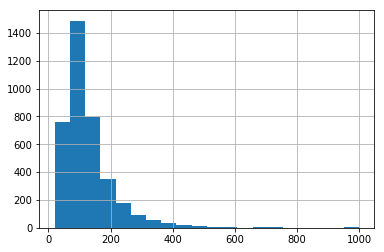

In [120]:
# Analyzing: Outliers
# Outliers need to be handled as they can affect linear regression badly
df['price'].hist(bins=20)

Looking at the distribution of the prices, it looks like prices over 600 usd per day are outliers and we can remove those datapoints, as outliers usually affect linear regression badly.

In [141]:
# Removing outliers in price column as they may affect linear regression
# 600 seems like a reasonable upper bound

df = df[df['price'] <=600]

In [142]:
# Putting all together in a function
def listings_preprocessing(listings):
    """
    Preprocessing on the listings dataset for linear regression:
        Selecting relevant nymerical features
        One hot encoding of categorical variables (including amenities)
        Removing columns with most null values
        Converting price column to float
        Encoding of binary variables 't,f'
        Imputing missing values in numerical columns with median
        
    """
    # Extracting numerical features
    df = listings.select_dtypes(include=['int64','float64']).copy()
    # Dropping non-relevant ones (at least the ones I believe not to be)
    df.drop(['host_id','scrape_id','latitude','longitude',
            'minimum_nights','maximum_nights','availability_30','availability_60','availability_90',
            'availability_365','calculated_host_listings_count'],axis=1, inplace=True)
    # This ones are removed as column is almost empty
    df.drop(['square_feet','license'], axis=1, inplace=True)
    #We keep  the review_scores_ratings among all review scores
    df.drop(['review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
            'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
            'reviews_per_month'], axis=1, inplace=True)
    df['price'] = listings['price'].apply(fix_price)
    # One-hot encoding of categorical fetures
    for categorical_feature in ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']:
        df = pd.concat([df, pd.get_dummies(listings[categorical_feature])], axis=1)
    # Amenities column
    listings.amenities = listings.amenities.str.replace("[{}\"]", "")
    df = pd.concat([df, listings.amenities.str.get_dummies(sep = ",")])
    # True/False variables
    for tf_feature in ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']:
        df[tf_feature] = listings[tf_feature].map(lambda s: False if s == "f" else True)
    
    # Imputing median to fill null values in mumerical columns
    for col in df.columns[df.isnull().any()]:
        df[col] = df[col].fillna(df[col].median())
    #Removing outliers in price column as they may affect linear regression
    df = df[df['price'] <=600]
        
    return df
    

## Which features affect the price the most?
We want to find which features affect the price the most. We will use a linear regression model and analyze the coefficients. We are not expecting the model to perform great in terms of minimizing the loss in the predictions as we are applying a very basic model without much optimizations (all default parameters), but we are mostly interested in how the predictors affect the final price, which ones are most important in driving the prices up and which ones bring a discount from the base price. Also we will fit the model to the whole dataset, as we are not looking at optimizing loss on a cross validated test vset.

In [145]:
# Finally, time to get down to business: Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def lr_model(df_listings):
    """
    Instantiate and fit linear regression model. Predict prices on the whole dataset
    Predict prices and compute (squared root of ) mean squared error and r2 score.
    """
    model = LinearRegression()
    y = df_listings['price']
    X = df_listings.drop('price', axis=1)
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return model, rmse, r2

In [144]:
# Fitting the model on Seattle dataset, computing predictions, mean squared error and r2 score

df_seattle = listings_preprocessing(s_listings)
s_model, s_rmse, s_r2 = lr_model(df_seattle)
print("Seattle mean squared error (square root): ",s_rmse)
print("seattle r2 score: ",s_r2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Seattle mean squared error (square root):  34.0910046479317
seattle r2 score:  0.654438679369618


This indicates that usually our model misses the right price by something around 34 usd.
R-squared is a statistical measure of how close the data are to the fitted regression line.
R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
Our result therefore says that predictors can explain around 65% of the variability.
So that's not really great, but expected considering the simplicity of the model.

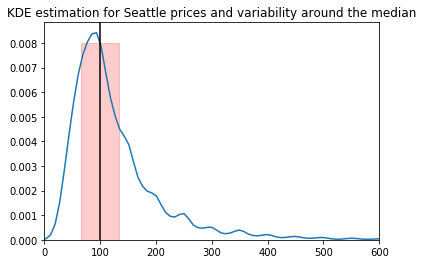

In [155]:
# Visualizing : Showing  prices variabilkity around the median
import matplotlib.patches as patches

Y = df_seattle.price
ax = sns.kdeplot(y, legend=False)
ax.set_xlim([0, 600])
plt.axvline(y.median(), c='black')
ax.add_patch(patches.Rectangle((y.median() - s_rmse, 0), 2*s_rmse, 0.008,
                      color='r', alpha=0.2)
)
plt.title('KDE estimation for Seattle prices and variability around the median');

In [163]:
# Visuaizing coefficients
#So that's not really great, but expected considering the simplicity of the model
#Let's have a look at the coeficients of the linear regression to understand which features are most relevant
def takefirst(elem):
    return abs(elem[0])

lr_coefficients = list(zip(s_model.coef_, df_seattle.drop('price', axis=1)))
lr_coefficients.sort(key=takefirst, reverse=True)
lr_coefficients

[(-146.94347089967883, 'Dorm'),
 (68.25972482167906, 'Pioneer Square'),
 (-67.94079475589764, 'South Park'),
 (60.357794326420844, 'Industrial District'),
 (58.70596215750001, 'Treehouse'),
 (51.99198743076855, 'Pike-Market'),
 (48.429901264920005, 'Loft'),
 (47.23449708117595, 'Camper/RV'),
 (-45.22375821926611, 'Haller Lake'),
 (-44.317494979659784, 'Crown Hill'),
 (43.97695308527201, 'Bed & Breakfast'),
 (-42.931881668954816, 'South Delridge'),
 (-41.46121090556291, 'Pinehurst'),
 (41.211057267253004, 'Cabin'),
 (-41.05371006899816, 'South Beacon Hill'),
 (-38.719704987155225, 'Mid-Beacon Hill'),
 (38.02152204715441, 'Southeast Magnolia'),
 (37.67666843213613, 'Boat'),
 (-36.25038194291158, 'North Delridge'),
 (-36.191039120862705, 'Columbia City'),
 (-36.12779402671842, 'Broadview'),
 (-36.11183242556157, 'Georgetown'),
 (35.96307271603044, 'South Lake Union'),
 (35.53804364158648, 'Entire home/apt'),
 (-35.447998815488766, 'Shared room'),
 (34.811893166583154, 'Sunset Hill'),
 (33

### So what predictors affect the price the most?
Answer:

Analysis: it seems that neighborhoods are quite important in affecting prices (as expected), looking the difference between trendy suburbs (+68 usd) and bad ones (-67 usd)

Staying in a dorm or sharing a room gives good savings, while choosing a loft comes at a premium. 
Additional bedrooms and bathrooms will cost you 31 usd and 22 usd respectevely, not as much as expected, but understandable considering these are not hotel rooms but privately rented apartments.

Seaview is surpisingly negative (-14$) so people in the west coast don't fancy a seaview? But... wait a minute, that doesn't refer to that an apartment "with" seaview  but to an apartment "in" Seaview (a neighborhood in Seattle, and apparently not a great one https://www.trulia.com/real_estate/Seaview-Seattle/6872/crime/).


The review_scores_rating is almost neutral (0.51) and so is number of reviews (-0,20) 

So since it seems that neighborhoods are what matter most (that's reat estate for you), let's have a look at them with a plot.

Text(0.5,1,'Seattle Neighborhoods Average Pricing')

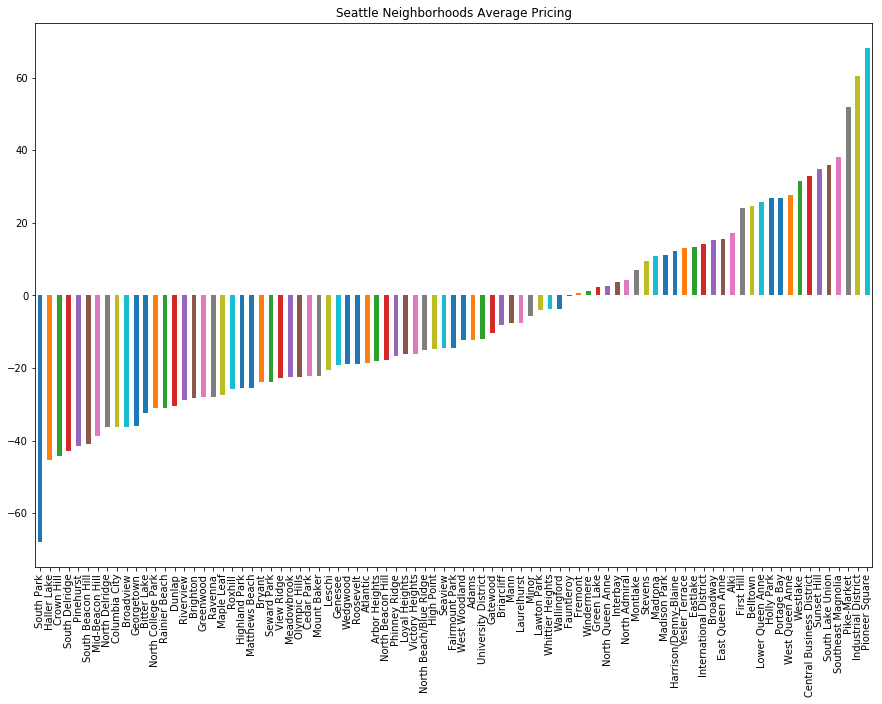

In [172]:
# We can dig into the neighborhoods: visualizing how neighborhoods affect price
neighborhoods = np.unique(s_listings['neighbourhood_cleansed'])
n_coeff = [c for c in lr_coefficients if c[1] in neighborhoods]
n_coeff
n_s=pd.Series(data=[n[0] for n in n_coeff], index=[n[1] for n in n_coeff]).sort_values()

#Plot
n_s.plot(kind='bar',figsize=(15,10), )
plt.title('Seattle Neighborhoods Average Pricing')

Good neighborhoods can come at a premium of 60+ usd, although the majority of them are under the 40 usd threshold. Similarly, most bad (or simply far from the trendy areas) neighborhoods bring a discount in the 0 to 40 usd range, with the exception of the infamous South Park.

### Are there other features affecting the price? What about the amenities offered, like TV, Wi-fi, etc.

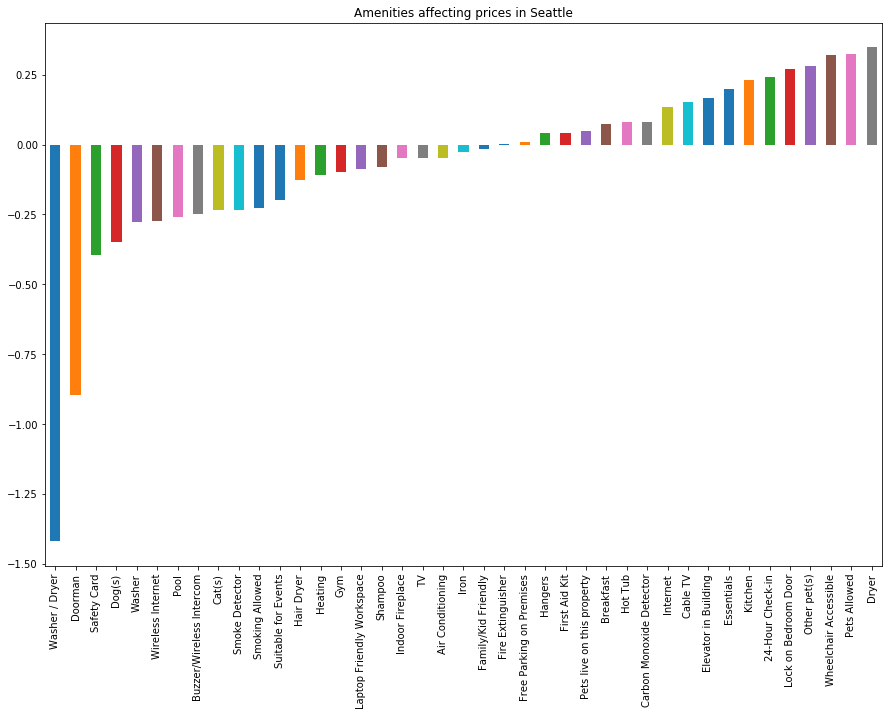

In [175]:
# The same can be plotted for the amenities offered
#amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|"))))[1:]
amenities = np.unique(np.concatenate(s_listings['amenities'].str.replace("[{}\"]", "").map(lambda a : a.split(','))))[1:]
a_coeff = [c for c in lr_coefficients if c[1] in amenities]
a_s = pd.Series(data=[n[0] for n in a_coeff], index=[n[1] for n in a_coeff]).sort_values()
a_s.plot(kind='bar', figsize=(15,10))
plt.title('Amenities affecting prices in Seattle');

The plot shows that, unlike neioghborhoods, amenties in Seattle don't influence the price too much as most of coefficients are below the 1 usd threshold. One interpretation is that most of them are nowadays taken for granted by the clients so they are not a differentiatior anymore. We will see if we get something more interesting in Boston

In [169]:
#Let's have a look at Boston
# we drop 3 columns that are not in the Seattle dataset
df_boston = listings_preprocessing(b_listings.drop(['has_availability', 'jurisdiction_names', 'neighbourhood_group_cleansed'],
                                                   axis=1))
b_model, b_rmse, b_r2 = lr_model(df_boston)
print("Boston mean squared error (square root): ",b_rmse)
print("Boston r2 score: ",b_r2)

/Users/maurizio/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Boston mean squared error (square root):  43.44719958673559
Boston r2 score:  0.6332069401107867


The mean squared error is Boston is a bit larger that Seattle (43 usd vs 34) but this does not come as a surprise considering that Boston mean price is also bigger (201 vs 137 usd).

In [170]:
blr_coefficients = list(zip(b_model.coef_, df_boston.drop('price', axis=1).columns))
blr_coefficients.sort(key=takefirst, reverse=True)
blr_coefficients

[(-148.4743609150414, 'Camper/RV'),
 (87.17787067661092, 'Bay Village'),
 (80.02620129599474, 'Leather District'),
 (77.53528128296125, 'South Boston Waterfront'),
 (68.90307972994566, 'Back Bay'),
 (67.09022781407035, 'Downtown'),
 (59.10348969496028, 'Other'),
 (54.10699737337878, 'Beacon Hill'),
 (-50.15312445424381, 'Dorm'),
 (-48.35401320759308, 'Roslindale'),
 (48.06623713162935, 'Chinatown'),
 (-47.158822286146915, 'Entire Floor'),
 (44.28084375846035, 'South End'),
 (-41.85738530119314, 'Hyde Park'),
 (40.83186493912932, 'Entire home/apt'),
 (-40.138757365901725, 'Mattapan'),
 (39.89775473186953, 'Fenway'),
 (-35.4428661789594, 'Dorchester'),
 (-35.3926813866032, 'West Roxbury'),
 (34.85115812603955, 'bedrooms'),
 (29.043418984979002, 'North End'),
 (29.02026711735644, 'Charlestown'),
 (-26.77782969849591, 'Shared room'),
 (22.22867901810519, 'require_guest_phone_verification'),
 (-20.168410342703016, 'Brighton'),
 (-19.392831368511846, 'Jamaica Plain'),
 (17.07379283958516, 'B

Text(0.5,1,'Boston Neighborhoods Average Pricing')

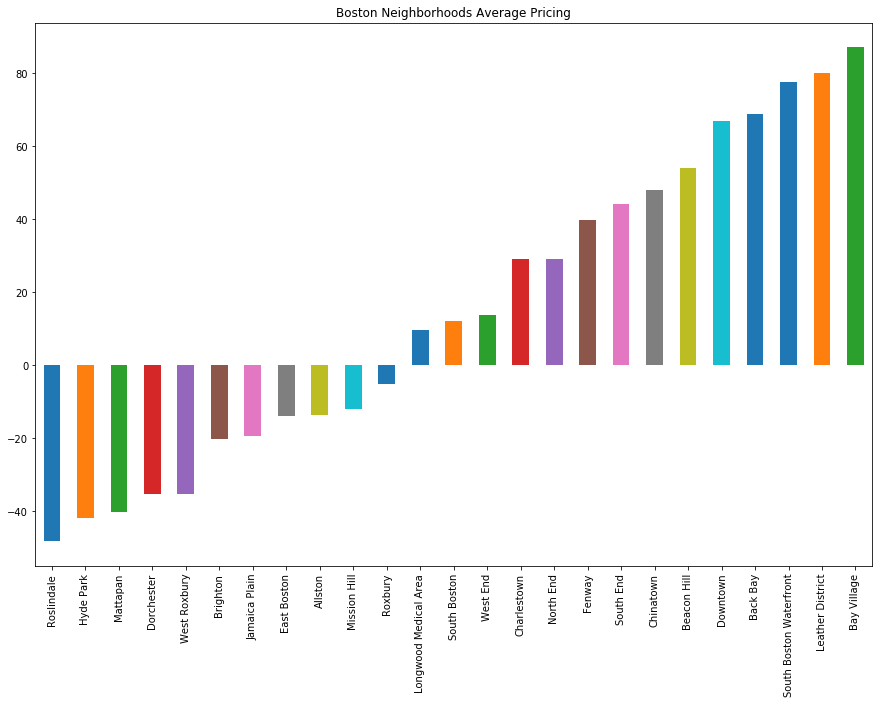

In [176]:
#We can have a look at Boston neighborhoods, too
# We can dig into the neighborhoods
b_neighborhoods = np.unique(b_listings['neighbourhood_cleansed'])
n_coeff = [c for c in blr_coefficients if c[1] in b_neighborhoods]
n_coeff
n_s=pd.Series(data=[n[0] for n in n_coeff], index=[n[1] for n in n_coeff]).sort_values()

#Plot
n_s.plot(kind='bar',figsize=(15,10))
plt.title('Boston Neighborhoods Average Pricing')

As for Seattle, in Boston too sought after areas come at a premium (here up to 87 usd) while the discount coming from stay away from the centre or good areas is not as beneficial as it was in Seattle. 

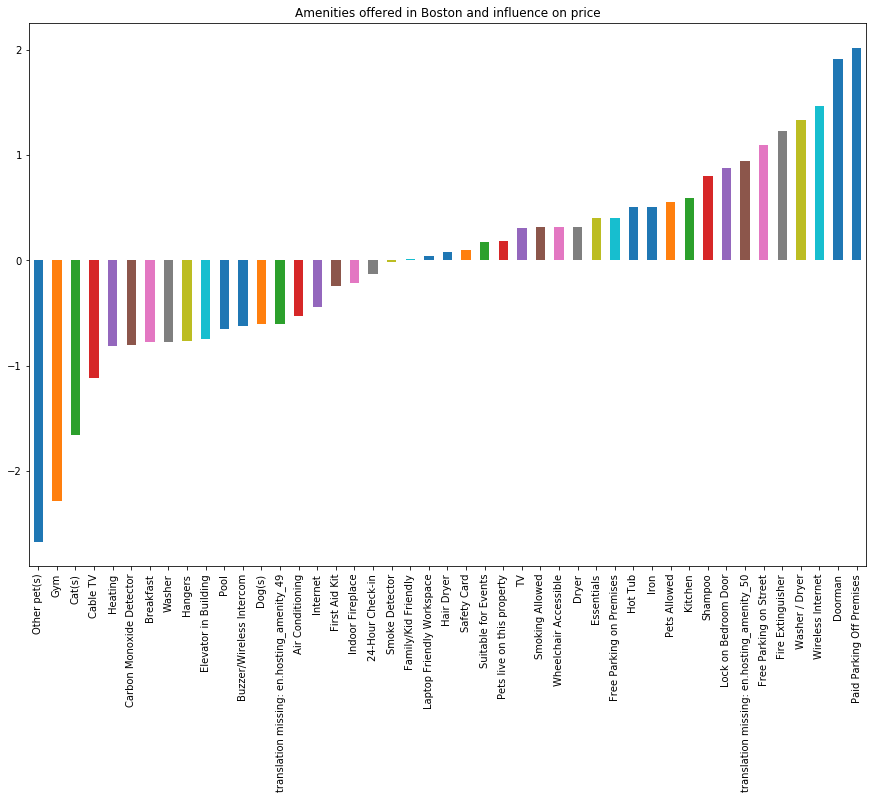

In [182]:
# Amenities in Boston
amenities = np.unique(np.concatenate(b_listings['amenities'].str.replace("[{}\"]", "").map(lambda a : a.split(','))))[1:]
a_coeff = [c for c in blr_coefficients if c[1] in amenities]
a_s = pd.Series(data=[n[0] for n in a_coeff], index=[n[1] for n in a_coeff]).sort_values()
a_s.plot(kind='bar', figsize=(15,10))
plt.title('Amenities offered in Boston and influence on price');

The data here looks a bit more interesting tham Seattle, althoiugh the influence on price is again very low and under 2 usd. Paid Parking wi-fi and doorman are appreciated, while availability to allow pets in the apartment seems to bring a discount maybe because it can put some clients off.